# Deep learning for timeseries

A timeseries can be any data obtained via measurements at regular intervals, like the daily price of a stock, the hourly electricity consumption of a city, or the weekly sales of a store. Timeseries are everywhere, whether we’re looking at natural phenomena (like seismic activity, the evolution of fish populations in a river, or the weather at a location) or human activity patterns (like visitors to a website, a country’s GDP, or credit card transactions). Unlike the types of data you’ve encountered so far, working with timeseries involves understanding the dynamics of a system—its periodic cycles, how it trends over time, its regular regime and its sudden spikes.

By far, the most common timeseries-related task is forecasting: predicting what will happen next in a series. Forecast electricity consumption a few hours in advance so you can anticipate demand; forecast revenue a few months in advance so you can plan your budget; forecast the weather a few days in advance so you can plan your schedule. Forecasting is what this chapter focuses on. But there’s actually a wide range of other things you can do with timeseries:

* Classification—Assign one or more categorical labels to a timeseries. For instance, given the timeseries of the activity of a visitor on a website, classify whether the visitor is a bot or a human.
    

    
* Event detection—Identify the occurrence of a specific expected event within a continuous data stream. A particularly useful application is “hotword detection,” where a model monitors an audio stream and detects utterances like “Ok Google” or “Hey Alexa.”

* Anomaly detection—Detect anything unusual happening within a continuous datastream. Unusual activity on your corporate network? Might be an attacker. Unusual readings on a manufacturing line? Time for a human to go take a look. Anomaly detection is typically done via unsupervised learning, because you often don’t know what kind of anomaly you’re looking for, so you can’t train on specific anomaly examples.



## A temperature-forecasting example

Predict the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the recent past by a set of sensors on the roof of a building

We’ll work with a weather timeseries dataset recorded at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany.1 In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.



In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-10-26 02:46:24--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.13.22, 52.216.105.125, 52.217.227.224, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.13.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  56.7MB/s    in 0.2s    

2023-10-26 02:46:24 (56.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(lines[0])
print("\nHow many rows ::" ,len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30

How many rows :: 420451


This outputs a count of 420,551 lines of data (each line is a timestep: a record of a date and 14 weather-related values)

**Parsing the data**

convert all 420,551 lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features we will use to predict future temperatures. Note that we discard the “Date Time” column.

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

Figure shows the plot of temperature (in degrees Celsius) over time. On this plot, you can clearly see the yearly periodicity of temperature—the data spans 8 years



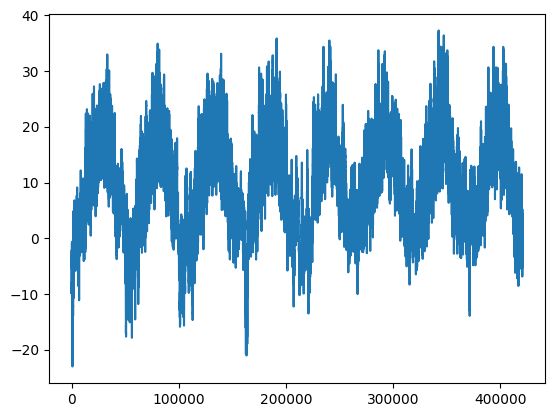

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

Figure shows a more narrow plot of the first 10 days of temperature data. Because the data is recorded every 10 minutes, you get 24 × 6 = 144 data points per day.



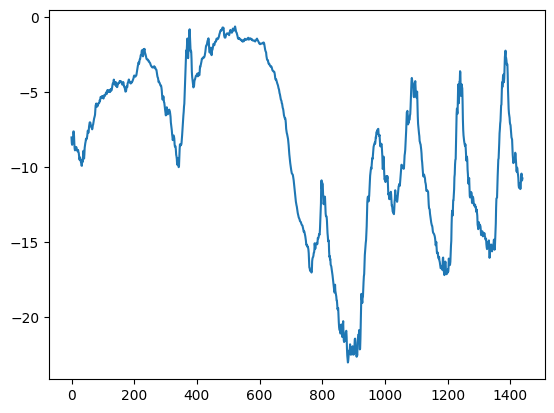

In [5]:
plt.plot(range(1440), temperature[:1440])

On this plot, you can see daily periodicity, especially for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month.

With our dataset, if you were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic.


In this experiments, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to predict the future given the past, not the reverse, and your validation/test splits should reflect that.

**Computing the number of samples we'll use for each data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

Given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

**Normalizing the data**

First, let’s preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per mole, is around 3). We’ll normalize each timeseries independently so that they all take small values on a similar scale. We’re going to use the first 210,225 timesteps as training data, so we’ll compute the mean and standard deviation only on this fraction of the data.

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
print("mean: " , mean)
print("\nstd: ",std)

mean:  [ 988.74929466    8.82590329  282.9050718     4.31331863   75.87275476
   13.14569946    9.19414209    3.95148184    5.81050741    9.30208943
 1218.45204015    2.14977462    3.56048029  176.4405232 ]

std:  [ 8.50510865  8.77098361  8.86560463  7.08011256 16.62877917  7.6012955
  4.14689697  4.76961017  2.63277288  4.1996886  42.0392747   1.53358803
  2.32305586 85.85032063]


#### Create timeseries dataset

Next, let’s create a Dataset object that yields batches of data from the past five days along with a target temperature 24 hours in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate memory for every sample. Instead, we’ll generate the samples on the fly while only keeping in memory the original raw_data and temperature arrays, and nothing more.

To understand what timeseries_dataset_from_array() does, let’s look at a simple example. The general idea is that you provide an array of timeseries data (the data argument), and timeseries_dataset_from_array() gives you windows extracted from the original timeseries (we’ll call them “sequences”).

    For example, if you use data = [0 1 2 3 4 5 6] and sequence_length=3, then timeseries_dataset_from_array() will generate the following samples: [0 1 2], [1 2 3], [2 3 4], [3 4 5], [4 5 6].

    You can also pass a targets argument (an array) to timeseries_dataset_ from_array(). The first entry of the targets array should match the desired target for the first sequence that will be generated from the data array. So if you’re doing timeseries forecasting, targets should be the same array as data, offset by some amount.

    For instance, with data = [0 1 2 3 4 5 6 ...] and sequence_length=3, you could create a dataset to predict the next step in the series by passing targets = [3 4 5 6





In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


❶ Generate an array of sorted integers from 0 to 9.

❷ The sequences we generate will be sampled from [0 1 2 3 4 5 6].

❸ The target for the sequence that starts at data[N] will be data[N + 3].

❹ The sequences will be 3 steps long.

❺ The sequences will be batched in batches of size 2.




**Instantiating datasets for training, validation, and testing**

We’ll use timeseries_dataset_from_array() to instantiate three datasets: one for training, one for validation, and one for testing.

We’ll use the following parameter values:
* sampling_rate = 6—Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
* sequence_length = 120—Observations will go back 5 days (120 hours).
* delay = sampling_rate * (sequence_length + 24 - 1)—The target for a sequence will be the temperature 24 hours after the end of the sequence.

When making the training dataset, we’ll pass start_index = 0 and end_index = num_train_samples to only use the first 50% of the data. For the validation dataset, we’ll pass start_index = num_train_samples and end_index = num_train_samples + num_val_samples to use the next 25% of the data. Finally, for the test dataset, we’ll pass start_index = num_train_samples + num_val_samples to use the remaining samples.



In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures. Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1]) aren’t necessarily temporally close.

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

Before we start using black-box deep learning models to solve the temperature-prediction problem, let’s try a simple, common-sense approach. It will serve as a sanity check, and it will establish a baseline that we’ll have to beat in order to demonstrate the usefulness of more-advanced machine learning models. Such common-sense baselines can be useful when you’re approaching a new problem for which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes are much more common than others. If your dataset contains 90% instances of class A and 10% instances of class B, then a common-sense approach to the classification task is to always predict “A” when presented with a new sample. Such a classifier is 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes, such elementary baselines can prove surprisingly hard to beat.

In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now. Let’s evaluate this approach, using the mean absolute error (MAE) metric


**Computing the common-sense baseline MAE**

The temperature feature is at column 1, so samples[:, -1, 1] is the last temperature measurement in the input sequence. Recall that we normalized our features, so to retrieve a temperature in degrees Celsius, we need to un-normalize it by multiplying it by the standard deviation and adding back the mean.

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


This common-sense baseline achieves a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. So if you always assume that the temperature 24 hours in the future will be the same as it is now, you will be off by two and a half degrees on average. It’s not too bad, but you probably won’t launch a weather forecasting service based on this heuristic. Now the game is to use your knowledge of deep learning to do better.

### Let's try a basic machine-learning model

In the same way that it’s useful to establish a common-sense baseline before trying machine learning approaches, it’s useful to try simple, cheap machine learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.

**Training and evaluating a densely connected model**

The following listing shows a fully connected model that starts by flattening the data and then runs it through two Dense layers. Note the lack of an activation function on the last Dense layer, which is typical for a regression problem. We use mean squared error (MSE) as the loss, rather than MAE, because unlike MAE, it’s smooth around zero, which is a useful property for gradient descent. We will monitor MAE by adding it as a metric in compile().



In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

mc = ModelCheckpoint(filepath='jena_dense.h5', verbose=1, monitor='val_loss')
cb = [mc]

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callbacks = [
#     keras.callbacks.ModelCheckpoint("jena_dense.keras",
#                                     save_best_only=True)
# ]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=cb)

model = keras.models.load_model("jena_dense.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
815/819 [============================>.] - ETA: 0s - loss: 11.7195 - mae: 2.6646
Epoch 1: saving model to jena_dense.h5
819/819 [==============================] - 51s 56ms/step - loss: 11.7187 - mae: 2.6647 - val_loss: 10.8449 - val_mae: 2.6183
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - ETA: 0s - loss: 8.9452 - mae: 2.3536
Epoch 2: saving model to jena_dense.h5
819/819 [==============================] - 39s 48ms/step - loss: 8.9452 - mae: 2.3536 - val_loss: 10.2470 - val_mae: 2.5362
Epoch 3/10
819/819 [==============================] - ETA: 0s - loss: 8.3031 - mae: 2.2674
Epoch 3: saving model to jena_dense.h5
819/819 [==============================] - 48s 58ms/step - loss: 8.3031 - mae: 2.2674 - val_loss: 10.1301 - val_mae: 2.5167
Epoch 4/10
811/819 [============================>.] - ETA: 0s - loss: 7.8865 - mae: 2.2117
Epoch 4: saving model to jena_dense.h5
819/819 [==============================] - 47s 57ms/step - loss: 7.8887 - mae: 2.2119 - val_loss: 10.3803 - val_mae: 2.5504
Epoch 5/10
814/819 [============================>.] - ETA: 0s - loss: 7.5687 - mae: 2.1663
Epoch 5: saving model to jena_dense.h5
819/819 [==============================] - 48s 58ms/step - loss: 7.5694 - mae: 2.1661 - val_loss: 11.7161 - val_mae: 2.

**Plotting results**

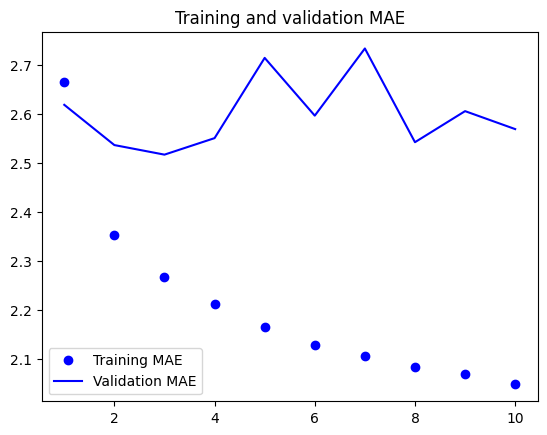

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Some of the validation losses are close to the no-learning baseline, but not reliably. This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform. Your common sense contains a lot of valuable information to which a machine learning model doesn’t have access.

You may wonder, if a simple, well-performing model exists to go from the data to the targets (the common-sense baseline), why doesn’t the model you’re training find it and improve on it? Well, the space of models in which you’re searching for a solution—that is, your hypothesis space—is the space of all possible two-layer networks with the configuration you defined. The common-sense heuristic is just one model among millions that can be represented in this space. It’s like looking for a needle in a haystack. Just because a good solution technically exists in your hypothesis space doesn’t mean you’ll be able to find it via gradient descent.

That’s a pretty significant limitation of machine learning in general: unless the learning algorithm is hardcoded to look for a specific kind of simple model, it can sometimes fail to find a simple solution to a simple problem. That’s why leveraging good feature engineering and relevant architecture priors is essential: you need to precisely tell your model what it should be looking for


### Let's try a 1D convolutional model

Since our input sequences feature daily cycles, perhaps a convolutional model could work. A temporal convnet could reuse the same representations across different days, much like a spatial convnet can reuse the same representations across different locations in an image.

Let’s try one on our temperature-forecasting problem. We’ll pick an initial window length of 24, so that we look at 24 hours of data at a time (one cycle). As we downsample the sequences (via MaxPooling1D layers), we’ll reduce the window size accordingly:

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 44s 46ms/step - loss: 22.8832 - mae: 3.7104 - val_loss: 15.7185 - val_mae: 3.1479
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 15.2838 - mae: 3.1006 - val_loss: 15.6890 - val_mae: 3.1194
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 14.0659 - mae: 2.9707 - val_loss: 14.7320 - val_mae: 3.0230
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 13.2895 - mae: 2.8836 - val_loss: 16.2340 - val_mae: 3.1669
Epoch 5/10
819/819 [==============================] - 38s 46ms/step - loss: 12.6482 - mae: 2.8117 - val_loss: 15.3342 - val_mae: 3.0904
Epoch 6/10
819/819 [==============================] - 37s 45ms/step - loss: 12.1058 - mae: 2.7466 - val_loss: 16.7671 - val_mae: 3.2634
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 11.7172 - mae: 2.7004 - val_loss: 14.3512 - val_mae: 2.9968
Epoch 8/10
819/819 [============================

### A first recurrent baseline

Neither the fully connected approach nor the convolutional approach did well, but that doesn’t mean machine learning isn’t applicable to this problem. The densely connected approach first flattened the timeseries, which removed the notion of time from the input data. The convolutional approach treated every segment of the data in the same way even applying pooling, which destroyed order information. Let’s instead look at the data as what it is: a sequence, where causality and order matter.

There’s a family of neural network architectures designed specifically for this use case: recurrent neural networks. Among them, the Long Short Term Memory (LSTM) layer has long been very popular

**A simple LSTM-based model**

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 53s 61ms/step - loss: 39.7059 - mae: 4.5783 - val_loss: 11.9589 - val_mae: 2.6249
Epoch 2/10
819/819 [==============================] - 49s 60ms/step - loss: 10.8724 - mae: 2.5595 - val_loss: 9.7866 - val_mae: 2.4269
Epoch 3/10
819/819 [==============================] - 48s 59ms/step - loss: 9.8789 - mae: 2.4471 - val_loss: 9.7197 - val_mae: 2.4208
Epoch 4/10
819/819 [==============================] - 49s 59ms/step - loss: 9.5967 - mae: 2.4085 - val_loss: 9.7982 - val_mae: 2.4270
Epoch 5/10
819/819 [==============================] - 40s 48ms/step - loss: 9.4120 - mae: 2.3843 - val_loss: 9.7138 - val_mae: 2.4125
Epoch 6/10
819/819 [==============================] - 40s 48ms/step - loss: 9.2797 - mae: 2.3662 - val_loss: 9.8284 - val_mae: 2.4272
Epoch 7/10
819/819 [==============================] - 49s 59ms/step - loss: 9.1909 - mae: 2.3525 - val_loss: 10.1185 - val_mae: 2.4526
Epoch 8/10
819/819 [==============================] - 40s 

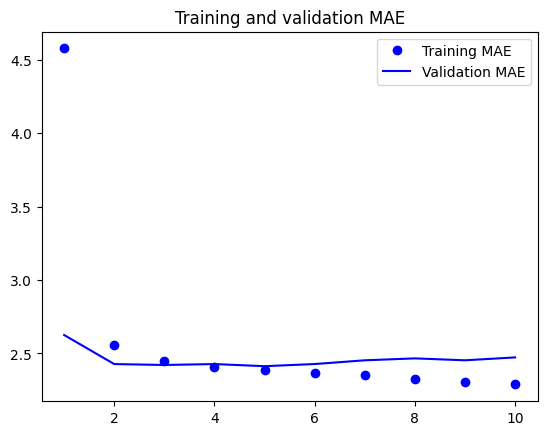

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Figure shows the results. Much better! We achieve a validation MAE as low as 2.39 degrees and a test MAE of 2.55 degrees. The LSTM-based model can finally beat the common-sense baseline (albeit just by a bit, for now), demonstrating the value of machine learning on this task.



## Understanding recurrent neural networks

A major characteristic of all neural networks you’ve seen so far, such as densely connected networks and convnets, is that they have no memory. Each input shown to them is processed independently, with no state kept between inputs. With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point. For instance, this is what we did in the densely connected network example: we flattened our five days of data into a single large vector and processed it in one go. Such networks are called feedforward networks.

In contrast, as you’re reading the present sentence, you’re processing it word by word—or rather, eye saccade by eye saccade—while keeping memories of what came before; this gives you a fluid representation of the meaning conveyed by this sentence. Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in.

A recurrent neural network (RNN) adopts the same principle, albeit in an extremely simplified version: it processes sequences by iterating through the sequence elements and maintaining a state that contains information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop



### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [18]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

All recurrent layers in Keras (SimpleRNN, LSTM, and GRU) can be run in two different modes: they can return either full sequences of successive outputs for each timestep (a rank-3 tensor of shape (batch_size, timesteps, output_features)) or return only the last output for each input sequence (a rank-2 tensor of shape (batch_ size, output_features)). These two modes are controlled by the return_sequences constructor argument. Let’s look at an example that uses SimpleRNN and returns only the output at the last timestep.



**An RNN layer that returns only its last output step**

In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [20]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


It’s sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all of the intermediate layers to return a full sequence of outputs.

**Stacking RNN layers**

In [21]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In practice, you’ll rarely work with the SimpleRNN layer. It’s generally too simplistic to be of real use. In particular, SimpleRNN has a major issue: although it should theoretically be able to retain at time t information about inputs seen many timesteps before, such long-term dependencies prove impossible to learn in practice. This is due to the vanishing gradient problem, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable.

## Advanced use of recurrent neural networks

* Recurrent dropout—This is a variant of dropout, used to fight overfitting in recurrent layers.
* Stacking recurrent layers—This increases the representational power of the model (at the cost of higher computational loads).
* Bidirectional recurrent layers—These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 366s 442ms/step - loss: 28.9512 - mae: 3.9704 - val_loss: 10.0219 - val_mae: 2.4511
Epoch 2/50
819/819 [==============================] - 371s 453ms/step - loss: 14.8874 - mae: 2.9908 - val_loss: 9.5429 - val_mae: 2.3873
Epoch 3/50
819/819 [==============================] - 361s 441ms/step - loss: 14.0371 - mae: 2.9016 - val_loss: 9.4307 - val_mae: 2.3665
Epoch 4/50
819/819 [==============================] - 359s 438ms/step - loss: 13.5058 - mae: 2.8461 - val_loss: 9.2634 - val_mae: 2.3507
Epoch 5/50
819/819 [==============================] - 361s 440ms/step - loss: 13.1163 - mae: 2.8062 - val_loss: 9.3150 - val_mae: 2.3593
Epoch 6/50
429/819 [==============>...............] - ETA: 2:40 - loss: 12.9280 - mae: 2.7768

KeyboardInterrupt: ignored

This code defines a LSTM model with dropout regularization to predict the temperature in Jena, Germany based on historical weather data.

The `inputs` variable defines the input shape of the model as a 3D tensor with shape `(sequence_length, num_features)`, where `sequence_length` is the number of time steps in the input sequence and `num_features` is the number of features in each time step.

The `x` variable defines the LSTM layer with 32 units and a recurrent dropout rate of 0.25, which helps prevent overfitting by randomly dropping out some of the LSTM units during training.

The `x` variable also defines a dropout layer with a rate of 0.5, which randomly drops out some of the output values from the LSTM layer during training to further prevent overfitting.

The `outputs` variable defines the output layer of the model as a dense layer with a single unit, which predicts the temperature at the next time step.

The `model` variable defines the Keras model using the `inputs` and `outputs` variables.

The `callbacks` variable defines a list of callbacks to be used during training. In this case, the `ModelCheckpoint` callback is used to save the best model during training based on the validation loss.

The `model.compile` method compiles the model using the RMSprop optimizer, the mean squared error loss function, and the mean absolute error metric.

The `model.fit` method trains the model on the training dataset for 50 epochs, using the validation dataset for validation during training, and the `callbacks` list to save the best model during training.


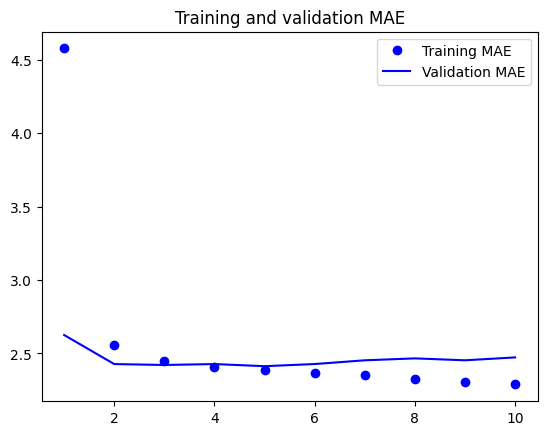

In [23]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Stacking recurrent layers

Because you’re no longer overfitting but seem to have hit a performance bottleneck, you should consider increasing the capacity and expressive power of the network. Recall the description of the universal machine learning workflow: it’s generally a good idea to increase the capacity of your model until overfitting becomes the primary obstacle (assuming you’re already taking basic steps to mitigate overfitting, such as using dropout). As long as you aren’t overfitting too badly, you’re likely under capacity.

Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build more-powerful recurrent networks: for instance, not too long ago the Google Translate algorithm was powered by a stack of seven large LSTM layers

In the following example, we’ll try a stack of two dropout-regularized recurrent layers. For a change, we’ll use Gated Recurrent Unit (GRU) layers instead of LSTM. GRU is very similar to LSTM—you can think of it as a slightly simpler, streamlined version of the LSTM architecture.

**Training and evaluating a dropout-regularized, stacked GRU model**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.h5")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 681s 825ms/step - loss: 25.1157 - mae: 3.7019 - val_loss: 9.8305 - val_mae: 2.4243
Epoch 2/5
819/819 [==============================] - 667s 814ms/step - loss: 13.9864 - mae: 2.8964 - val_loss: 9.0764 - val_mae: 2.3277
Epoch 3/5
819/819 [==============================] - 641s 782ms/step - loss: 13.0994 - mae: 2.8089 - val_loss: 9.2705 - val_mae: 2.3516
Epoch 4/5
819/819 [==============================] - 635s 775ms/step - loss: 12.5257 - mae: 2.7455 - val_loss: 9.0169 - val_mae: 2.3236
Epoch 5/5
819/819 [==============================] - 642s 784ms/step - loss: 12.0864 - mae: 2.6943 - val_loss: 8.9500 - val_mae: 2.3136


405/405 [==============================] - 38s 92ms/step - loss: 9.9153 - mae: 2.4558
Test MAE: 2.46


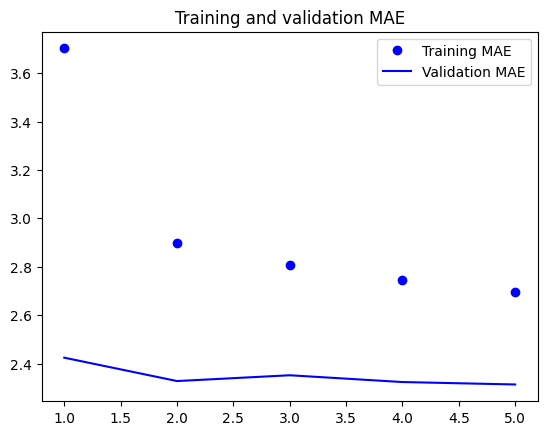

In [25]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)

Epoch 1/5
819/819 [==============================] - 48s 54ms/step - loss: 27.0502 - mae: 3.7552 - val_loss: 10.2652 - val_mae: 2.4705
Epoch 2/5
819/819 [==============================] - 45s 55ms/step - loss: 9.8058 - mae: 2.4423 - val_loss: 10.0999 - val_mae: 2.4525
Epoch 3/5
819/819 [==============================] - 43s 53ms/step - loss: 8.8065 - mae: 2.3132 - val_loss: 10.2712 - val_mae: 2.4769
Epoch 4/5
819/819 [==============================] - 44s 54ms/step - loss: 8.1922 - mae: 2.2308 - val_loss: 10.3564 - val_mae: 2.4760
Epoch 5/5
819/819 [==============================] - 43s 53ms/step - loss: 7.7682 - mae: 2.1705 - val_loss: 10.3821 - val_mae: 2.4701


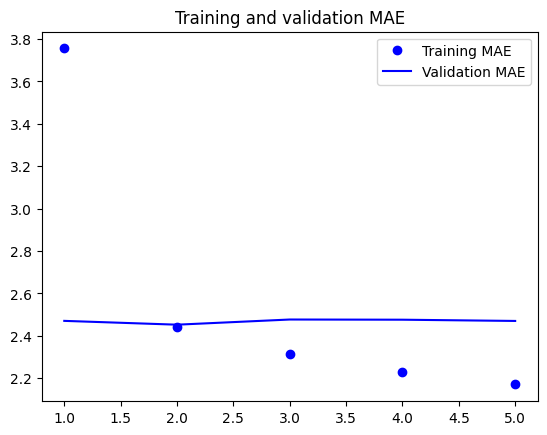

In [27]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Summary